In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import data

In [2]:
url_gas = 'https://www.eia.gov/petroleum/gasdiesel/xls/pswrgvwall.xls'
gas_prices = pd.read_excel(url_gas, sheet_name='Data 1', skiprows=2, parse_dates=['Date'])

url_diesel = 'https://www.eia.gov/petroleum/gasdiesel/xls/psw18vwall.xls'
diesel_prices = pd.read_excel(url_diesel, sheet_name='Data 1', skiprows=2, parse_dates=['Date'])

In [3]:
elec_url = 'https://www.eia.gov/electricity/data/eia861m/xls/sales_revenue.xlsx'

# Get monthly residential electricity data
electricity_prices = pd.read_excel(elec_url, sheet_name='Monthly-States', usecols='A:D, H', 
                            skiprows=2, skipfooter=1, parse_dates= {"period" : ["Year","Month"]},)

us_elec = pd.read_excel(elec_url, sheet_name='US-YTD', usecols='A:C, G', 
                            skiprows=2, skipfooter=1)#, parse_dates= {"Date" : ["Year","Month"]},)

# Price in Cents/kWh
electricity_prices = electricity_prices.rename(columns={'Cents/kWh': 'price'})
us_elec = us_elec.rename(columns={'Cents/kWh': 'price'})

us_elec = us_elec[us_elec['MONTH'] != '.']
us_elec['day'] = '1'

us_elec['period'] = pd.to_datetime(us_elec[['Year', 'MONTH', 'day']])
us_elec = us_elec.drop(['Year', 'MONTH', 'day'], axis=1)



In [4]:
electricity_prices.sort_values(by='period', inplace=True)
us_elec.sort_values(by='period', inplace=True)

In [5]:
def column_rename(df, sub2):
    '''Function to rename columns in the gas and diesel price DataFrames. Removes everything before
    and after the first and second substrings, including the substrings.
    
    Args:
        df: DataFrame whose columns need to be renamed (either gas_prices or diesel_prices).
        sub2(str): Second substring to search for in each header. This will remove everything after 
            and including this string
            
    Returns:
        df: returns the dataframe with renamed columns.
         '''
    columns = df.columns.values.tolist()

    sub1 = 'Weekly '
    sub2 = sub2

    new_column = []
    for name in columns:
        if sub1 in name:

            # get index of substrings
            idx1 = name.index(sub1)
            idx2 = name.index(sub2)

            new_name = name[idx1 + len(sub1): idx2]
            new_column += [new_name]

        else:
            new_column += [name]

    column_dict = dict(zip(columns, new_column))

    df = df.rename(columns=column_dict)
    return df

diesel_prices = column_rename(diesel_prices, ' No 2')
gas_prices = column_rename(gas_prices, ' Regular')

In [9]:
# Resample gas and diesel prices to give the average monthly price to be the same as electricity prices
gas_prices_resample = gas_prices.resample('MS', on='Date').mean()
diesel_prices_resample = diesel_prices.resample('MS', on='Date').mean()

In [6]:
# Dictionary of state names from https://gist.github.com/JeffPaine/3083347
states = {
    'AK': 'Alaska',
    'AL': 'Alabama',
    'AR': 'Arkansas',
    'AZ': 'Arizona',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DC': 'District of Columbia',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'IA': 'Iowa',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'MA': 'Massachusetts',
    'MD': 'Maryland',
    'ME': 'Maine',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MO': 'Missouri',
    'MS': 'Mississippi',
    'MT': 'Montana',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'NE': 'Nebraska',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NV': 'Nevada',
    'NY': 'New York',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VA': 'Virginia',
    'VT': 'Vermont',
    'WA': 'Washington',
    'WI': 'Wisconsin',
    'WV': 'West Virginia',
    'WY': 'Wyoming'
}

state_names = list(states.values())

In [7]:
electricity_prices['stateDescription'] = electricity_prices['State'].map(states)

## Forecasts

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels as sm

In [15]:
# Train-Test-Split US gas and electric prices
gas_prices_resample.reset_index(inplace=True)
gas_all = gas_prices_resample[['Date', 'U.S.']]
gas_all = gas_all.set_index(pd.DatetimeIndex(gas_all['Date']))
gas_all = gas_all.drop('Date', axis=1)
gas_train = gas_all[gas_all.index < '2021-01-01']
gas_test = gas_all[gas_all.index >= '2021-01-01']

electric_train = us_elec[us_elec['period'] < '2018-01-01'][['period', 'price']]
electric_test = us_elec[us_elec['period'] >= '2018-01-01'][['period', 'price']]
electric_all = us_elec[['period', 'price']]

In [16]:
format = '%Y-%m-%d %H:%M:%S'

electric_train.loc['period'] = pd.to_datetime(electric_train['period'], format=format)
electric_train = electric_train.set_index(pd.DatetimeIndex(electric_train['period']))
electric_train = electric_train.drop('period', axis=1)
electric_train = electric_train.dropna()

electric_all.loc['period'] = pd.to_datetime(electric_all['period'], format=format)
electric_all = electric_all.set_index(pd.DatetimeIndex(electric_all['period']).to_period('M'))
electric_all = electric_all.drop('period', axis=1)
electric_all = electric_all.dropna()

/Users/richardbradshaw/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


<AxesSubplot:xlabel='period'>

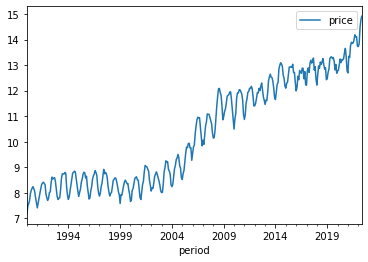

In [93]:
electric_all.plot()

## Electricity forecasting

In [17]:
# test for stationarity
from statsmodels.tsa.stattools import adfuller

adf = adfuller(electric_all.diff().dropna())
print('ADF Statistic electricity:', adf[0])
print('p-value electricity:', adf[1])

ADF Statistic electricity: -3.519954551881606
p-value electricity: 0.007489166238731118


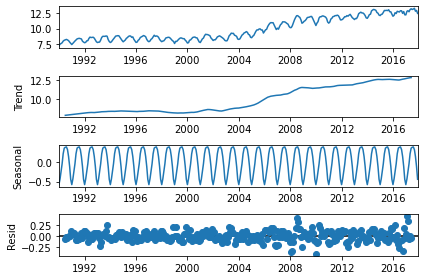

In [18]:
# test for seasonality
test = seasonal_decompose(electric_train, period=12)
test.plot();

<AxesSubplot:xlabel='period'>

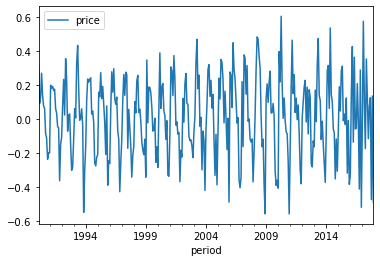

In [19]:
electric_train.diff().dropna().plot()

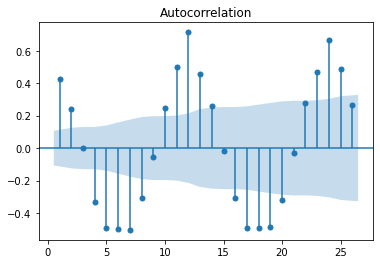

In [20]:
plot_acf(electric_train.diff().dropna(), zero=False);

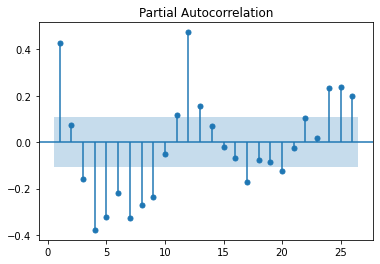

In [21]:
plot_pacf(electric_train.diff().dropna(), zero=False);

Both the ACF and PACF plots show 12 month seasonality

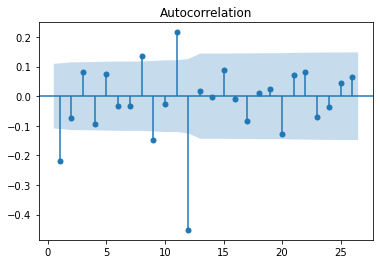

In [22]:
electric_train_diff = electric_train.diff().diff(12).dropna()

plot_acf(electric_train_diff, zero=False);

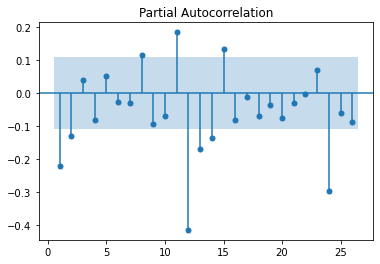

In [23]:
plot_pacf(electric_train_diff, zero=False);

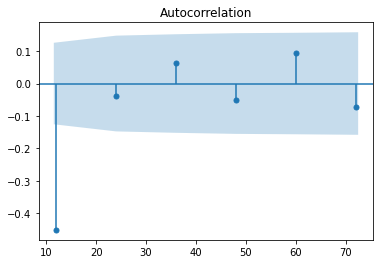

In [24]:
lags = [12, 24, 36, 48, 60, 72]

plot_acf(electric_train_diff, lags=lags);

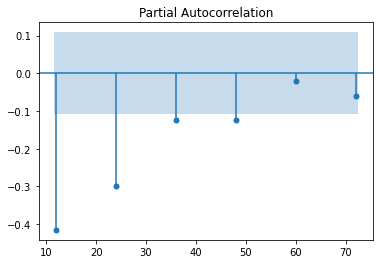

In [25]:
plot_pacf(electric_train_diff, lags=lags);

The ACF and PACF plots suggest 12-month seasonality, and first order differencing for the models. 

Next perform auto arima to select the best values for order and seasonal order in the models.

In [26]:
import pmdarima as pm 

# train = electric_train.set_index('period')

electric_model_best = pm.auto_arima(electric_train,
                      seasonal=True, m=12,
                      d=1, D=1, 
                      start_p=1, start_q=1,
                      max_p=1, max_q=1,
                      max_P=1, max_Q=1,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True) 

# Print model summary
print(electric_model_best.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-390.363, Time=0.96 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-252.716, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-338.162, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-393.629, Time=0.34 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-270.066, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-391.919, Time=0.53 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-342.873, Time=0.15 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-375.369, Time=0.26 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-392.174, Time=0.63 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-390.073, Time=0.39 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-391.651, Time=0.54 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 4.007 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y  

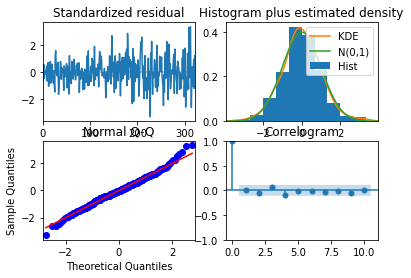

In [27]:
electric_model_best.plot_diagnostics();

In [28]:
electric_train_model = SARIMAX(electric_train, order=(0,1,1), seasonal_order=(0,1,1,12), intercept=True, freq='MS')
electric_results = electric_train_model.fit()

electric_results.summary()

/Users/richardbradshaw/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              price   No. Observations:                  336
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 199.814
Date:                            Wed, 10 Aug 2022   AIC                           -393.629
Time:                                    06:07:37   BIC                           -382.296
Sample:                                01-01-1990   HQIC                          -389.105
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2673      0.053     -5.048      0.000      -0.371      -0.163
ma.S.L12      -0.7450      0.036    -20.724      0.000      -0.816      -0.675
sigma2         0.0165      0.001     14.678      0.000       0.014       0.019
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 6.70
Prob(Q):                              0.84   Prob(JB):                         0.04
Heteroskedasticity (H):               2.95   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

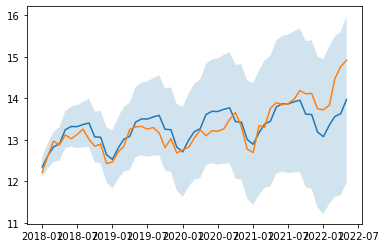

In [29]:
# Compare model with test data

electric_forecast = electric_results.get_forecast(steps=len(electric_test), dynamic=True)
electric_pred = electric_forecast.predicted_mean
electric_conf = electric_forecast.conf_int()

plt.plot(electric_test['period'], electric_pred)
plt.fill_between(electric_test['period'], electric_conf['lower price'], electric_conf['upper price'], alpha=0.2)
plt.plot(electric_test['period'], electric_test['price']);
# plt.plot(electric_train.index, electric_train['price']);

### Full electricity forecast

In [30]:
electric_model = SARIMAX(electric_all, order=(0,1,1), seasonal_order=(0,1,1,12), intercept=True)
electric_all_results = electric_model.fit()

electric_all_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              price   No. Observations:                  389
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 205.931
Date:                            Wed, 10 Aug 2022   AIC                           -405.862
Time:                                    06:07:54   BIC                           -394.073
Sample:                                01-31-1990   HQIC                          -401.182
                                     - 05-31-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2837      0.045     -6.271      0.000      -0.372      -0.195
ma.S.L12      -0.7736      0.029    -26.393      0.000      -0.831      -0.716
sigma2         0.0190      0.001     16.519      0.000       0.017       0.021
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                19.66
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               3.41   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

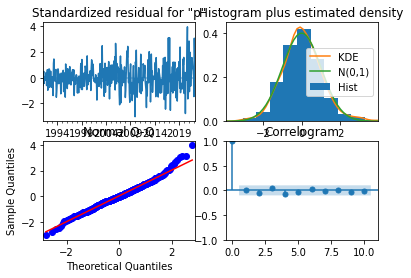

In [31]:
electric_all_results.plot_diagnostics();

In [32]:
from dateutil.relativedelta import relativedelta

start_date = electric_all.index.array[-1].to_timestamp() + relativedelta(months=1)

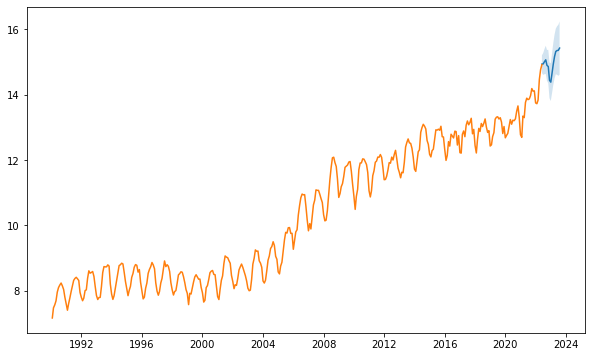

In [33]:
forecast_dates = pd.date_range(start=start_date, periods=15, freq='MS')
# forecast_dates = pd.date_range(start='6/1/2022', periods=15, freq='MS')

electric_all_pred = electric_all_results.get_forecast(steps=15, dynamic=True)
electric_all_pred_mean = electric_all_pred.predicted_mean
electric_all_conf = electric_all_pred.conf_int().set_index(forecast_dates)

electric_all_forecast = pd.DataFrame(electric_all_pred_mean).set_index(forecast_dates)
electric_all_forecast = pd.concat([electric_all_forecast, electric_all_conf], axis=1)

plt.subplots(figsize=(10,6))
plt.plot(electric_all_forecast.index, electric_all_forecast['predicted_mean'])
plt.fill_between(electric_all_forecast.index, electric_all_forecast['lower price'], 
                 electric_all_forecast['upper price'], alpha=0.2)
plt.plot(electric_all.index, electric_all['price']);

### Tennessee electricity price forecast

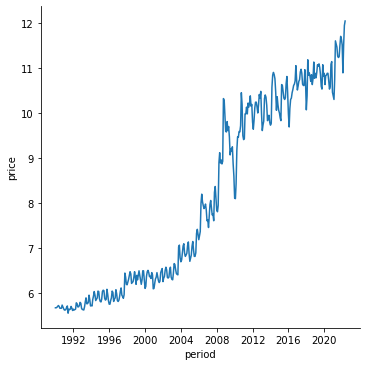

In [34]:
sns.relplot(x='period', y='price', data=electricity_prices[electricity_prices['State']=='TN'], kind='line');

In [35]:
def elec_state(state):
    temp = electricity_prices[electricity_prices['State'] == state][['period', 'price']]
    temp.set_index('period', inplace=True)
    temp.sort_index(inplace=True)
    return temp

In [36]:
elec_TN = elec_state('TN')

In [37]:
elec_TN.head()

,price
period,
1990-01-01,5.68
1990-02-01,5.68
1990-03-01,5.69
1990-04-01,5.71
1990-05-01,5.73


In [38]:
elec_TN_train = elec_TN[elec_TN.index < '2018-01-01']
elec_TN_test = elec_TN[elec_TN.index >= '2018-01-01']

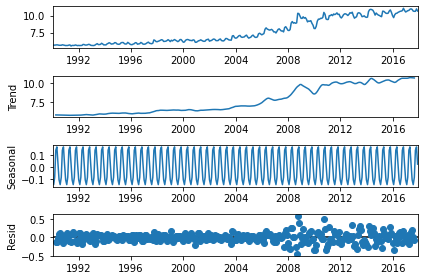

In [41]:
# test for seasonality
season_TN = seasonal_decompose(elec_TN_train, period=6)
season_TN.plot();

<AxesSubplot:xlabel='period'>

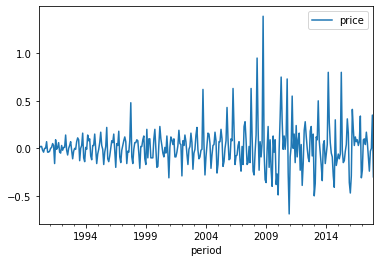

In [42]:
elec_TN_train.diff().dropna().plot()

<AxesSubplot:xlabel='period'>

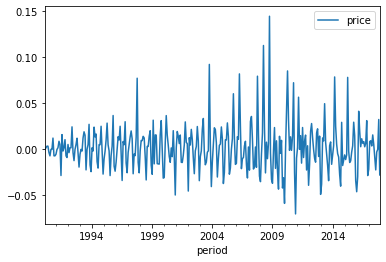

In [43]:
elec_TN_log_train = np.log(elec_TN_train)
elec_TN_log_train.diff().dropna().plot()

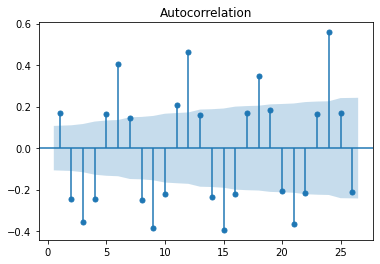

In [44]:
plot_acf(elec_TN_log_train.diff().dropna(), zero=False);

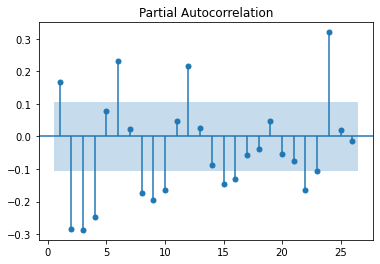

In [45]:
plot_pacf(elec_TN_log_train.diff().dropna(), zero=False);

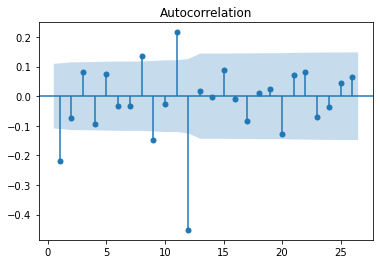

In [46]:
elec_TN_log_train_diff = elec_TN_log_train.diff().diff(6).dropna()

plot_acf(electric_train_diff, zero=False);

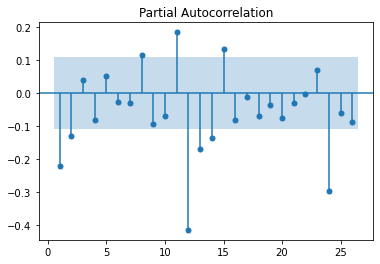

In [47]:
plot_pacf(electric_train_diff, zero=False);

In [48]:
# Need to do this on the elec_TN_train set...
elec_TN_best = pm.auto_arima(elec_TN_log_train,
                      seasonal=True, m=6,
                      d=1, D=1, 
                      start_p=1, start_q=1,
                      max_p=1, max_q=1,
                      max_P=1, max_Q=1,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True) 

# Print model summary
print(elec_TN_best.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=-1634.577, Time=0.51 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=-1430.966, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=-1543.710, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=-1633.299, Time=0.23 sec
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=-1631.459, Time=0.26 sec
 ARIMA(1,1,1)(1,1,0)[6]             : AIC=-1541.727, Time=0.14 sec
 ARIMA(1,1,1)(0,1,0)[6]             : AIC=-1427.238, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[6]             : AIC=-1633.104, Time=0.36 sec
 ARIMA(1,1,0)(1,1,1)[6]             : AIC=-1633.101, Time=0.45 sec
 ARIMA(0,1,0)(1,1,1)[6]             : AIC=-1635.091, Time=0.26 sec
 ARIMA(0,1,0)(0,1,1)[6]             : AIC=-1635.298, Time=0.12 sec
 ARIMA(0,1,0)(1,1,0)[6]             : AIC=-1545.684, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[6]             : AIC=-1633.299, Time=0.22 sec
 ARIMA(0,1,0)(0,1,1)[6] intercept   : AIC=-1633.320, Time=0.18 sec

Best model:  ARIMA

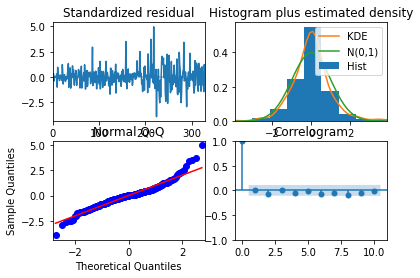

In [49]:
elec_TN_best.plot_diagnostics();

In [50]:
elec_TN_train_model = SARIMAX(elec_TN_log_train, order=(0,1,0), seasonal_order=(0,1,1,6), intercept=True, freq='MS')
elec_TN_results = elec_TN_train_model.fit()

elec_TN_results.summary()

/Users/richardbradshaw/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               price   No. Observations:                  336
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 6)   Log Likelihood                 819.649
Date:                             Wed, 10 Aug 2022   AIC                          -1635.298
Time:                                     06:09:20   BIC                          -1627.706
Sample:                                 01-01-1990   HQIC                         -1632.269
                                      - 12-01-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L6       -0.8967      0.013    -70.903      0.000      -0.921      -0.872
sigma2         0.0004   1.86e-05     20.997      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               175.78
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               3.76   Skew:                             0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

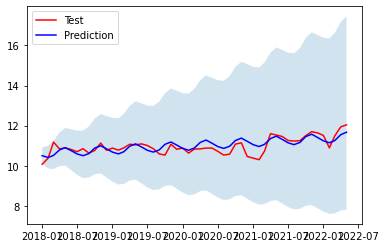

In [51]:
# Compare model with test data

elec_TN_forecast = elec_TN_results.get_forecast(steps=len(elec_TN_test), dynamic=True)
elec_TN_pred = elec_TN_forecast.predicted_mean
elec_TN_conf = elec_TN_forecast.conf_int()

elec_TN_pred = np.exp(elec_TN_pred)
elec_TN_conf = np.exp(elec_TN_conf)

plt.plot(elec_TN_test.index, elec_TN_test['price'], c='r')
plt.plot(elec_TN_test.index, elec_TN_pred, c='b')
plt.fill_between(elec_TN_test.index, elec_TN_conf['lower price'], elec_TN_conf['upper price'], alpha=0.2)
plt.legend(['Test', 'Prediction'], loc='upper left');
# plt.plot(electric_train.index, electric_train['price']);

### TN electricity forecast final

In [52]:
elec_TN_log = np.log(elec_TN)

In [53]:
elec_TN_model = SARIMAX(elec_TN_log, order=(0,1,0), seasonal_order=(0,1,1,6), intercept=True, freq='MS')
elec_TN_results = elec_TN_model.fit()

elec_TN_results.summary()

/Users/richardbradshaw/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               price   No. Observations:                  389
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 6)   Log Likelihood                 936.486
Date:                             Wed, 10 Aug 2022   AIC                          -1868.972
Time:                                     06:09:31   BIC                          -1861.081
Sample:                                 01-01-1990   HQIC                         -1865.841
                                      - 05-01-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L6       -0.9103      0.012    -75.158      0.000      -0.934      -0.887
sigma2         0.0004      2e-05     21.172      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):               138.80
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               3.23   Skew:                             0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

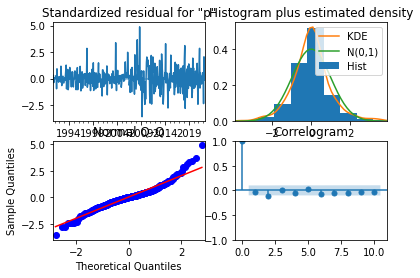

In [54]:
elec_TN_results.plot_diagnostics();

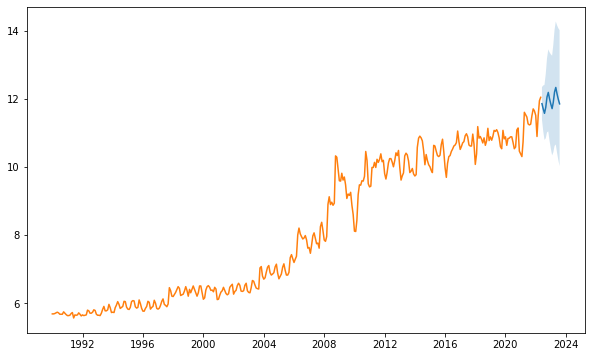

In [55]:
forecast_dates = pd.date_range(start=start_date, periods=15, freq='MS')
# forecast_dates = pd.date_range(start='6/1/2022', periods=15, freq='MS')

elec_TN_pred = elec_TN_results.get_forecast(steps=15, dynamic=True)
elec_TN_pred_mean = elec_TN_pred.predicted_mean
elec_TN_conf = elec_TN_pred.conf_int().set_index(forecast_dates)

elec_TN_pred_mean = np.exp(elec_TN_pred_mean)
elec_TN_conf = np.exp(elec_TN_conf)

elec_TN_forecast = pd.DataFrame(elec_TN_pred_mean).set_index(forecast_dates)
elec_TN_forecast = pd.concat([elec_TN_forecast, elec_TN_conf], axis=1)

plt.subplots(figsize=(10,6))
plt.plot(elec_TN_forecast.index, elec_TN_forecast['predicted_mean'])
plt.fill_between(elec_TN_forecast.index, elec_TN_forecast['lower price'], 
                 elec_TN_forecast['upper price'], alpha=0.2)
plt.plot(elec_TN.index, elec_TN['price']);

## Gas Forecast

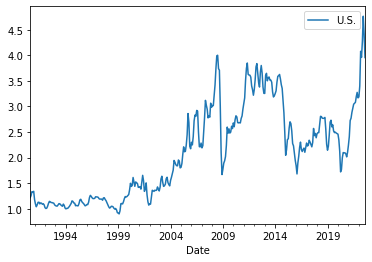

In [56]:
gas_all.plot();

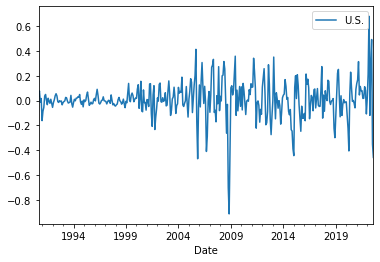

In [57]:
gas_all.diff().dropna().plot();

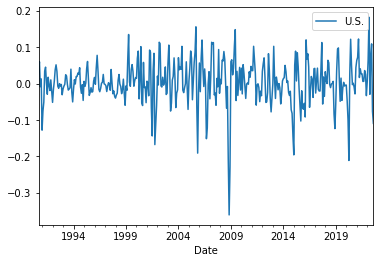

In [58]:
gas_log_all = np.log(gas_all)
gas_log_all.diff().dropna().plot();

In [59]:
gas_adf = adfuller(gas_log_all.diff().dropna())
print('ADF statistic ', gas_adf[0])
print('p-value ', gas_adf[1])

ADF statistic  -6.717092858925099
p-value  3.559301906970669e-09


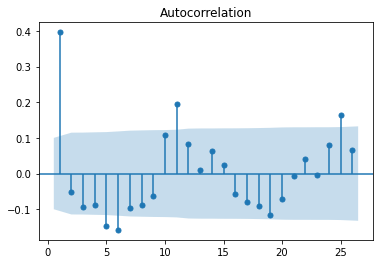

In [60]:
plot_acf(gas_log_all.diff().dropna(), zero=False);

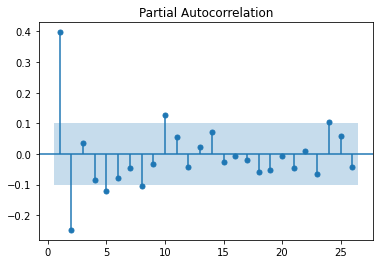

In [61]:
plot_pacf(gas_log_all.diff().dropna(), zero=False);

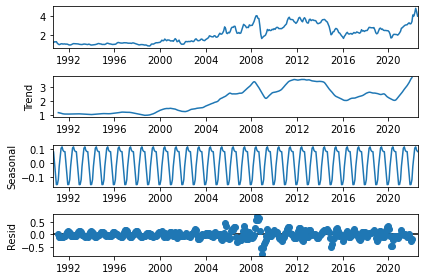

In [62]:
# test for seasonality
season_gas_TN = seasonal_decompose(gas_all, period=12)
season_gas_TN.plot();

<AxesSubplot:xlabel='Date'>

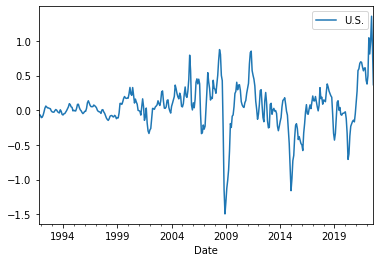

In [63]:
# plot ACF with no differencing to check for seasonality

gas_all_stationary = gas_all - gas_all.rolling(15).mean()
gas_all_stationary = gas_all_stationary.dropna()

gas_all_stationary.plot()

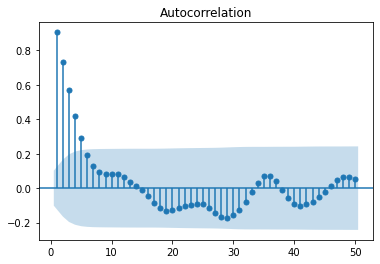

In [64]:
plot_acf(gas_all_stationary,lags = 50, zero=False);

In [65]:
gas_log_train = gas_log_all[gas_log_all.index < '2020-01-01']
gas_test = gas_all[gas_all.index >= '2020-01-01']

In [66]:
gas_model_best = pm.auto_arima(gas_log_train,
                      seasonal=False,
                      d=1, 
                      start_p=1, start_q=1,
                      max_p=2, max_q=2,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True)  

# Print model summary
print(gas_model_best.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1078.199, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-998.360, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1059.581, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1079.897, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-999.943, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1078.315, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1076.999, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1081.666, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1079.980, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-1080.099, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1061.395, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1077.696, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.969 seconds
                               SARIMAX Results                                

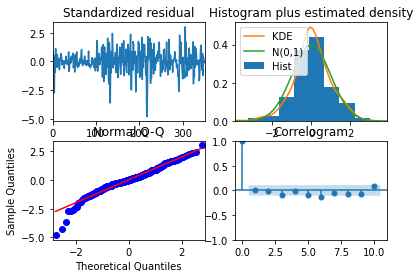

In [67]:
gas_model_best.plot_diagnostics();

In [68]:
gas_train_model = SARIMAX(gas_log_train, order=(0,1,1), intercept=True, freq='MS')

gas_train_results = gas_train_model.fit()

gas_train_results.summary()

/Users/richardbradshaw/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   U.S.   No. Observations:                  353
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 542.833
Date:                Wed, 10 Aug 2022   AIC                          -1081.666
Time:                        06:10:50   BIC                          -1073.939
Sample:                    08-01-1990   HQIC                         -1078.591
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5020      0.032     15.679      0.000       0.439       0.565
sigma2         0.0027      0.000     18.822      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):               124.41
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               2.43   Skew:                            -0.63
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

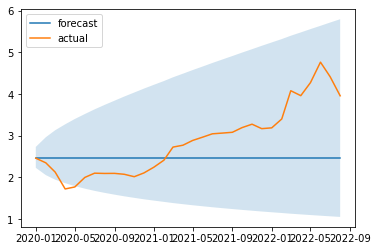

In [69]:
gas_train_forecast = gas_train_results.get_forecast(steps=len(gas_test), dynamic=True)
gas_train_pred = gas_train_forecast.predicted_mean
gas_train_conf = gas_train_forecast.conf_int()

gas_train_pred = np.exp(gas_train_pred)
gas_train_conf = np.exp(gas_train_conf)

plt.plot(gas_test.index, gas_train_pred)
plt.fill_between(gas_test.index, gas_train_conf['lower U.S.'], gas_train_conf['upper U.S.'], alpha=0.2)
plt.plot(gas_test)
plt.legend(['forecast', 'actual'], loc='upper left');

### all gas forecast

In [70]:
gas_model = SARIMAX(gas_log_all, order=(0,1,1), intercept=True, freq='MS')

gas_results = gas_model.fit()

/Users/richardbradshaw/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


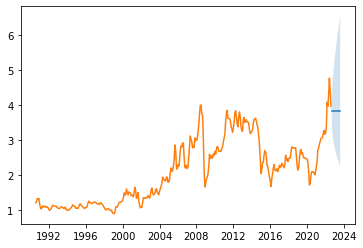

In [71]:
start_date_gas = gas_all.index.array[-1] + relativedelta(months=1)
forecast_dates_gas = pd.date_range(start=start_date_gas, periods=12, freq='MS')

gas_forecast = gas_results.get_forecast(steps=12, dynamic=True)
gas_pred = gas_forecast.predicted_mean
gas_conf = gas_forecast.conf_int()

gas_pred = np.exp(gas_pred)
gas_conf = np.exp(gas_conf)

gas_US_forecast = pd.DataFrame(gas_pred).set_index(forecast_dates_gas)
gas_US_forecast = pd.concat([gas_US_forecast, gas_conf], axis=1)

plt.plot(gas_pred)
plt.fill_between(gas_conf.index, gas_conf['lower U.S.'], gas_conf['upper U.S.'], alpha=0.2)
plt.plot(gas_all);

### Midwest Gas Forecast (Tennessee region)

In [72]:
gas_midwest = gas_prices_resample[['Date', 'Midwest']]
gas_midwest = gas_midwest.set_index(pd.DatetimeIndex(gas_midwest['Date']))
gas_midwest = gas_midwest.drop('Date', axis=1)
gas_midwest = gas_midwest.dropna()

gas_midwest_train = gas_midwest[gas_midwest.index < '2021-01-01']
gas_midwest_test = gas_midwest[gas_midwest.index >= '2021-01-01']

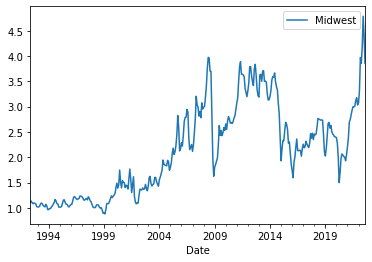

In [73]:
gas_midwest.plot();

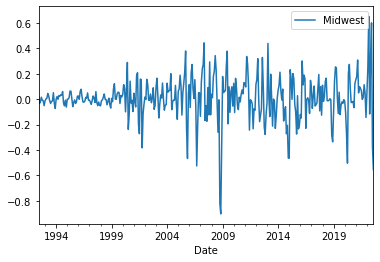

In [74]:
gas_midwest.diff().dropna().plot();

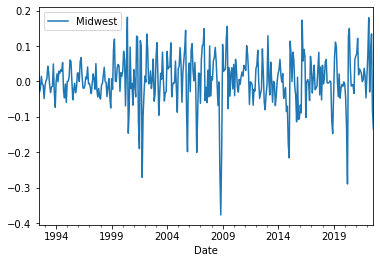

In [75]:
gas_midwest_log = np.log(gas_midwest)
gas_midwest_log.diff().dropna().plot();

In [76]:
gas_adf = adfuller(gas_midwest_log.diff().dropna())
print('ADF statistic ', gas_adf[0])
print('p-value ', gas_adf[1])

ADF statistic  -7.018487463120003
p-value  6.636995426689302e-10


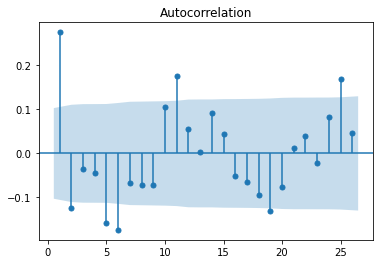

In [77]:
plot_acf(gas_midwest_log.diff().dropna(), zero=False);

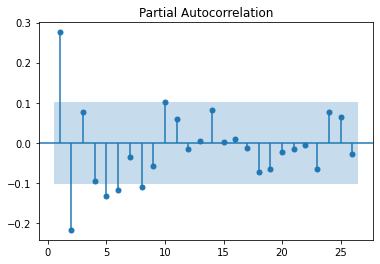

In [78]:
plot_pacf(gas_midwest_log.diff().dropna(), zero=False);

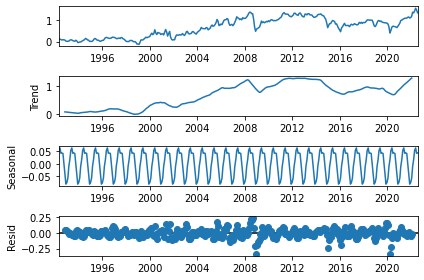

In [79]:
# test for seasonality
season_gas_TN = seasonal_decompose(gas_midwest_log, period=12)
season_gas_TN.plot();

<AxesSubplot:xlabel='Date'>

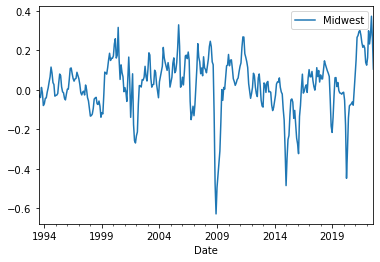

In [80]:
# plot ACF with no differencing to check for seasonality

gas_all_stationary = gas_midwest_log - gas_midwest_log.rolling(15).mean()
gas_all_stationary = gas_all_stationary.dropna()

gas_all_stationary.plot()

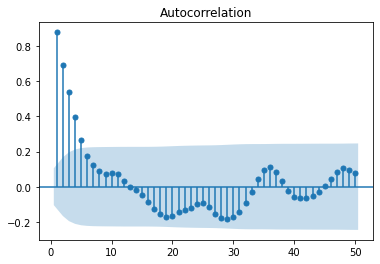

In [81]:
plot_acf(gas_all_stationary,lags = 50, zero=False);

In [82]:
gas_midwest_log_train = gas_midwest_log[gas_midwest_log.index < '2020-01-01']
gas_midwest_test = gas_midwest[gas_midwest.index >= '2020-01-01']

In [83]:
gas_midwest_model_best = pm.auto_arima(gas_midwest_log_train,
                      seasonal=False,
                      d=1, 
                      start_p=1, start_q=1,
                      max_p=1, max_q=1,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True)  

# Print model summary
print(gas_midwest_model_best.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-874.413, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-835.528, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-860.073, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-873.473, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-837.142, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-876.148, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-875.245, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-861.851, Time=0.01 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 0.372 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  332
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 441.074
Date:                Wed, 10 Aug 2022   AIC                           -876.148
Time:                        06:12:4

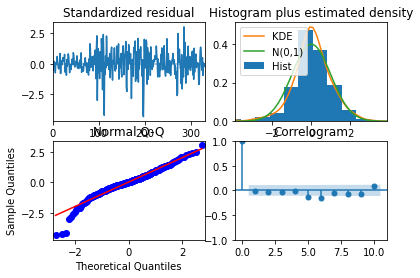

In [84]:
gas_midwest_model_best.plot_diagnostics();

In [96]:
gas_midwest_train_model = SARIMAX(gas_midwest_log_train, order=(1,1,1), intercept=True, freq='MS')

gas_midwest_train_results = gas_midwest_train_model.fit()

gas_midwest_train_results.summary()

/Users/richardbradshaw/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Midwest   No. Observations:                  332
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 441.074
Date:                Thu, 11 Aug 2022   AIC                           -876.148
Time:                        06:57:33   BIC                           -864.742
Sample:                    05-01-1992   HQIC                          -871.599
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2082      0.098     -2.135      0.033      -0.399      -0.017
ma.L1          0.5724      0.090      6.338      0.000       0.395       0.749
sigma2         0.0041      0.000     18.327      0.000       0.004       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               129.53
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.56   Skew:                            -0.68
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

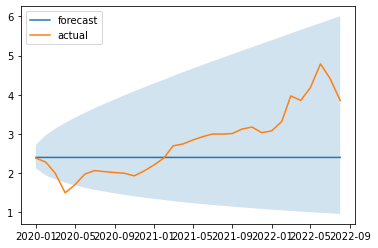

In [97]:
gas_midwest_train_forecast = gas_midwest_train_results.get_forecast(steps=len(gas_midwest_test), dynamic=True)
gas_midwest_train_pred = gas_midwest_train_forecast.predicted_mean
gas_midwest_train_conf = gas_midwest_train_forecast.conf_int()

gas_midwest_train_pred = np.exp(gas_midwest_train_pred)
gas_midwest_train_conf = np.exp(gas_midwest_train_conf)

plt.plot(gas_midwest_test.index, gas_midwest_train_pred)
plt.fill_between(gas_midwest_test.index, gas_midwest_train_conf['lower Midwest'], 
                 gas_midwest_train_conf['upper Midwest'], alpha=0.2)
plt.plot(gas_midwest_test)
plt.legend(['forecast', 'actual'], loc='upper left');

### all Midwest gas forecast

In [91]:
gas_midwest_model = SARIMAX(gas_midwest_log, order=(1,1,1), intercept=True, freq='MS')

gas_midwest_results = gas_midwest_model.fit()

/Users/richardbradshaw/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


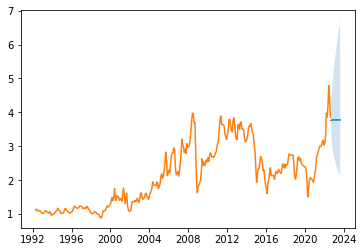

In [92]:
start_date_gas = gas_midwest_log.index.array[-1] + relativedelta(months=1)
forecast_dates_gas = pd.date_range(start=start_date_gas, periods=12, freq='MS')

gas_midwest_forecast = gas_midwest_results.get_forecast(steps=12, dynamic=True)
gas_midwest_pred = gas_midwest_forecast.predicted_mean
gas_midwest_conf = gas_midwest_forecast.conf_int()

gas_midwest_pred = np.exp(gas_midwest_pred)
gas_midwest_conf = np.exp(gas_midwest_conf)

gas_midwest_forecast = pd.DataFrame(gas_midwest_pred).set_index(forecast_dates_gas)
gas_midwest_forecast = pd.concat([gas_midwest_forecast, gas_midwest_conf], axis=1)

plt.plot(gas_midwest_pred)
plt.fill_between(gas_midwest_conf.index, gas_midwest_conf['lower Midwest'], 
                 gas_midwest_conf['upper Midwest'], alpha=0.2)
plt.plot(gas_midwest);

# OLD Forecasts

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels as sm

In [9]:
# Train-Test-Split US gas and electric prices
gas_all = gas_prices[['Date', 'U.S.']]
gas_all = gas_all.set_index(pd.DatetimeIndex(gas_all['Date']))
gas_all = gas_all.drop('Date', axis=1)
gas_train = gas_all[gas_all.index < '2021-01-01']
gas_test = gas_all[gas_all.index >= '2021-01-01']

electric_train = us_elec[us_elec['period'] < '2018-01-01'][['period', 'price']]
electric_test = us_elec[us_elec['period'] >= '2018-01-01'][['period', 'price']]
electric_all = us_elec[['period', 'price']]

In [10]:
format = '%Y-%m-%d %H:%M:%S'

electric_train['period'] = pd.to_datetime(electric_train['period'], format=format)
electric_train = electric_train.set_index(pd.DatetimeIndex(electric_train['period']))
electric_train = electric_train.drop('period', axis=1)

electric_all.loc['period'] = pd.to_datetime(electric_all['period'], format=format)
electric_all = electric_all.set_index(pd.DatetimeIndex(electric_all['period']).to_period('M'))
electric_all = electric_all.drop('period', axis=1)

/Users/richardbradshaw/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [11]:
electric_all = electric_all.dropna()

## Electricity forecasting

In [12]:
# test for stationarity
from statsmodels.tsa.stattools import adfuller

adf = adfuller(electric_all.diff().dropna())
print('ADF Statistic electricity:', adf[0])
print('p-value electricity:', adf[1])

ADF Statistic electricity: -3.519954551881606
p-value electricity: 0.007489166238731118


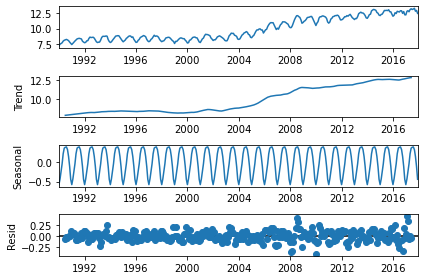

In [13]:
# test for seasonality
test = seasonal_decompose(electric_train, period=12)
test.plot();

<AxesSubplot:xlabel='period'>

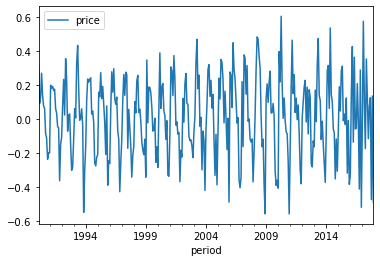

In [14]:
electric_train.diff().dropna().plot()

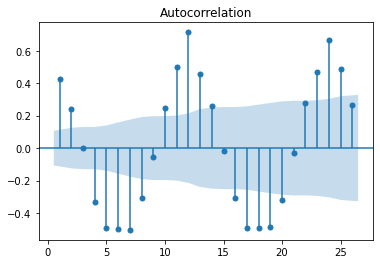

In [15]:
plot_acf(electric_train.diff().dropna(), zero=False);

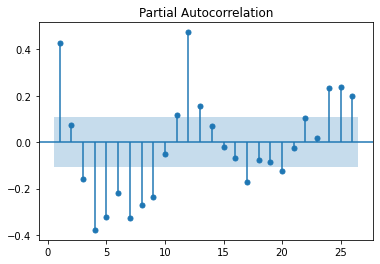

In [16]:
plot_pacf(electric_train.diff().dropna(), zero=False);

Both the ACF and PACF plots show 12 month seasonality

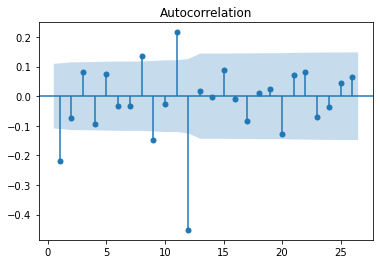

In [17]:
electric_train_diff = electric_train.diff().diff(12).dropna()

plot_acf(electric_train_diff, zero=False);

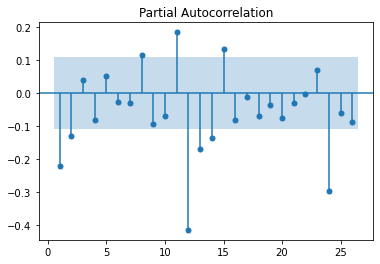

In [18]:
plot_pacf(electric_train_diff, zero=False);

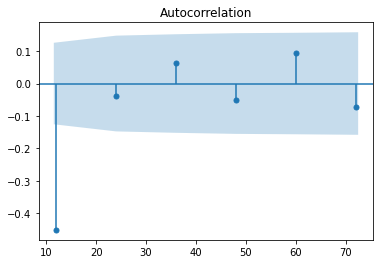

In [19]:
lags = [12, 24, 36, 48, 60, 72]

plot_acf(electric_train_diff, lags=lags);

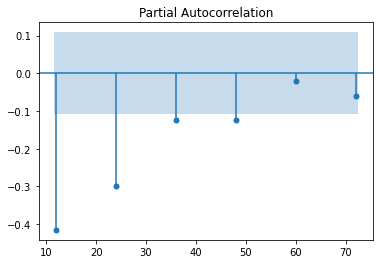

In [20]:
plot_pacf(electric_train_diff, lags=lags);

The ACF and PACF plots suggest 12-month seasonality, and first order differencing for the models. 

Next perform auto arima to select the best values for order and seasonal order in the models.

In [21]:
import pmdarima as pm 

test = electric_test.set_index('period')

electric_model_best = pm.auto_arima(test,
                      seasonal=True, m=12,
                      d=1, D=1, 
                      start_p=1, start_q=1,
                      max_p=1, max_q=1,
                      max_P=1, max_Q=1,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True) 

# Print model summary
print(electric_model_best.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=12.183, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-0.649, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=9.267, Time=0.02 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=0.020, Time=0.04 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-0.328, Time=0.18 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-1.908, Time=0.07 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5.546, Time=0.01 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(0,1,1)(1,1,0)[12] intercept   : AIC=-3.353, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=5.196, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.31 sec
 ARI

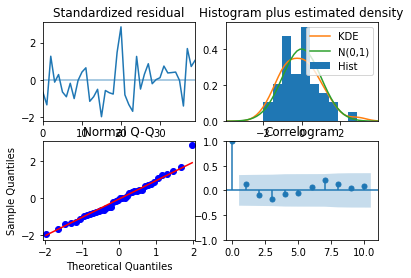

In [22]:
electric_model_best.plot_diagnostics();

In [23]:
electric_train_model = SARIMAX(electric_train, order=(0,1,1), seasonal_order=(1,1,0,12), intercept=True, freq='MS')
electric_results = electric_train_model.fit()

electric_results.summary()

/Users/richardbradshaw/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               price   No. Observations:                  336
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood                 174.436
Date:                             Mon, 01 Aug 2022   AIC                           -342.873
Time:                                     08:24:57   BIC                           -331.540
Sample:                                 01-01-1990   HQIC                          -338.349
                                      - 12-01-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2633      0.056     -4.687      0.000      -0.373      -0.153
ar.S.L12      -0.4603      0.047     -9.855      0.000      -0.552      -0.369
sigma2         0.0197      0.001     13.716      0.000       0.017       0.023
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 2.22
Prob(Q):                              0.67   Prob(JB):                         0.33
Heteroskedasticity (H):               2.78   Skew:                             0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

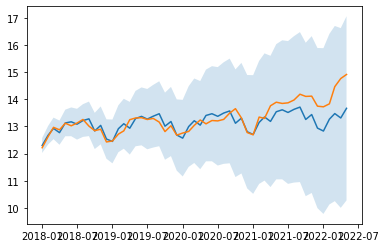

In [24]:
# Compare model with test data

electric_forecast = electric_results.get_forecast(steps=len(electric_test), dynamic=True)
electric_pred = electric_forecast.predicted_mean
electric_conf = electric_forecast.conf_int()

plt.plot(electric_test['period'], electric_pred)
plt.fill_between(electric_test['period'], electric_conf['lower price'], electric_conf['upper price'], alpha=0.2)
plt.plot(electric_test['period'], electric_test['price']);
# plt.plot(electric_train.index, electric_train['price']);

### Full electricity forecast

In [25]:
electric_model = SARIMAX(electric_all, order=(0,1,1), seasonal_order=(1,1,0,12), intercept=True)
electric_all_results = electric_model.fit()

electric_all_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               price   No. Observations:                  389
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood                 177.506
Date:                             Mon, 01 Aug 2022   AIC                           -349.012
Time:                                     08:24:58   BIC                           -337.223
Sample:                                 01-31-1990   HQIC                          -344.332
                                      - 05-31-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3081      0.042     -7.275      0.000      -0.391      -0.225
ar.S.L12      -0.4897      0.045    -10.841      0.000      -0.578      -0.401
sigma2         0.0226      0.001     16.182      0.000       0.020       0.025
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):                15.92
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               2.95   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

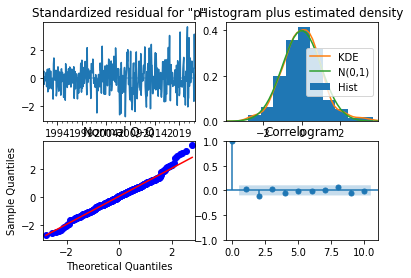

In [26]:
electric_all_results.plot_diagnostics();

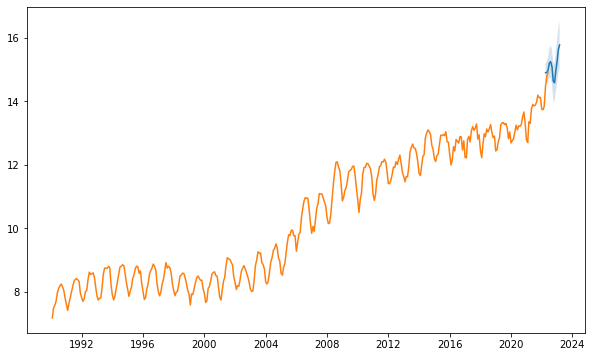

In [27]:
forecast_dates = pd.date_range(start='4/1/2022', periods=12, freq='MS')

electric_all_pred = electric_all_results.get_forecast(steps=12, dynamic=True)
electric_all_pred_mean = electric_all_pred.predicted_mean
electric_all_conf = electric_all_pred.conf_int().set_index(forecast_dates)

electric_all_forecast = pd.DataFrame(electric_all_pred_mean).set_index(forecast_dates)
electric_all_forecast = pd.concat([electric_all_forecast, electric_all_conf], axis=1)

plt.subplots(figsize=(10,6))
plt.plot(electric_all_forecast.index, electric_all_forecast['predicted_mean'])
plt.fill_between(electric_all_forecast.index, electric_all_forecast['lower price'], 
                 electric_all_forecast['upper price'], alpha=0.2)
plt.plot(electric_all.index, electric_all['price']);

In [28]:
electricity_prices.tail()

,period,State,Data Status,price,stateDescription
29,2022-05-01,NE,Preliminary,11.08,Nebraska
28,2022-05-01,ND,Preliminary,11.89,North Dakota
27,2022-05-01,NC,Preliminary,12.14,North Carolina
25,2022-05-01,MS,Preliminary,13.11,Mississippi
0,2022-05-01,AK,Preliminary,24.03,Alaska


In [29]:
# sns.relplot(x='period', y='price', data=electricity_prices, row='State', kind='line');

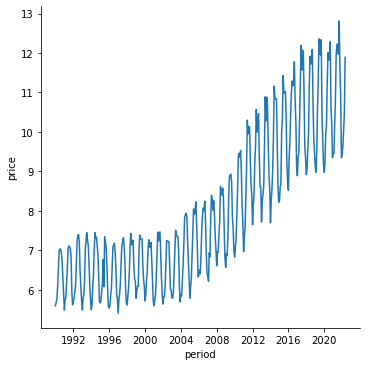

In [30]:
sns.relplot(x='period', y='price', data=electricity_prices[electricity_prices['State']=='ND'], kind='line');

In [31]:
# electricity_prices.groupby('State')['price'].agg([np.mean, np.median, np.std]).sort_values(by='mean')

In [32]:
elec_ND = electricity_prices[electricity_prices['State'] == 'ND'][['period', 'price']]
elec_ND.set_index('period', inplace=True)

In [33]:
elec_HI = electricity_prices[electricity_prices['State'] == 'HI'][['period', 'price']]
elec_HI.set_index('period', inplace=True)

In [34]:
def elec_state(state):
    temp = electricity_prices[electricity_prices['State'] == state][['period', 'price']]
    temp.set_index('period', inplace=True)
    return temp

In [35]:
elec_ID = elec_state('ID')

In [36]:
elec_ID.head()

,price
period,
1990-01-01,4.77
1990-02-01,4.79
1990-03-01,4.78
1990-04-01,4.85
1990-05-01,4.90


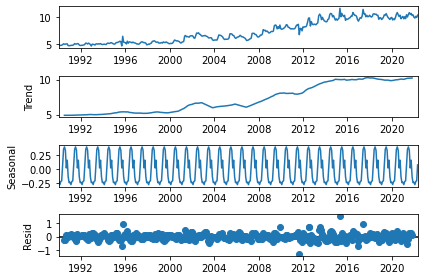

In [37]:
# test for seasonality
test = seasonal_decompose(elec_ID, period=12)
test.plot();

<AxesSubplot:xlabel='period'>

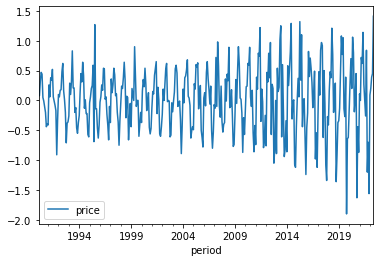

In [38]:
elec_ND.diff().dropna().plot()

In [39]:
def electric_model_best(df):
    best = pm.auto_arima(df,
                      seasonal=True, m=12,
                      d=1, D=1, 
                      start_p=1, start_q=1,
                      max_p=1, max_q=1,
                      max_P=1, max_Q=1,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True) 

    # Print model summary
    print(best.summary())
    
    best.plot_diagnostics();

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-33.115, Time=0.60 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=197.727, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=48.579, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-21.122, Time=0.29 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-35.115, Time=0.93 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=79.347, Time=0.12 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=3.563, Time=0.27 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1.024, Time=0.38 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=69.005, Time=0.18 sec
 ARIMA(1,1,1)(0,1,1)[12] intercept   : AIC=-33.304, Time=1.86 sec

Best model:  ARIMA(1,1,1)(0,1,1)[12]          
Total fit time: 4.813 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  389
Model:             SARIMAX(1, 1, 1)x(0, 1, 1

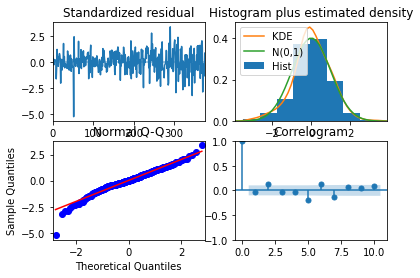

In [40]:
electric_model_best(elec_ND)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.91 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1105.806, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=964.608, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1071.942, Time=0.06 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.77 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1003.269, Time=0.07 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=953.766, Time=0.15 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1055.701, Time=0.06 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=978.913, Time=0.09 sec
 ARIMA(1,1,1)(1,1,0)[12] intercept   : AIC=955.620, Time=0.42 sec

Best model:  ARIMA(1,1,1)(1,1,0)[12]          
Total fit time: 4.090 seconds
                                     

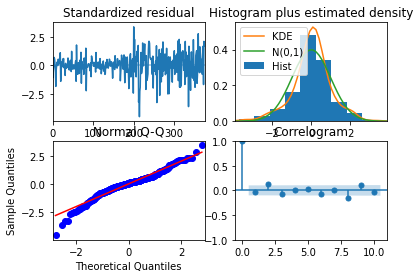

In [41]:
electric_model_best(elec_HI)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=109.913, Time=0.60 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=360.542, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=221.660, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=109.471, Time=0.40 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=260.574, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=108.564, Time=0.47 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=200.818, Time=0.11 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=132.602, Time=0.38 sec
 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=110.533, Time=1.62 sec

Best model:  ARIMA(0,1,1)(1,1,1)[12]          
Total fit time: 4.073 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  389
Model:             SARIMAX(0, 1, 1)x(1, 1

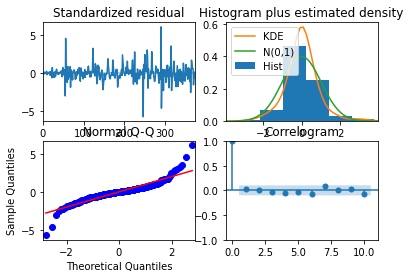

In [42]:
electric_model_best(elec_ID)

# Gas forecasts

In [43]:
gas_all = gas_all.dropna()
gas_2000_all = gas_all[gas_all.index >= '2001-01-01']

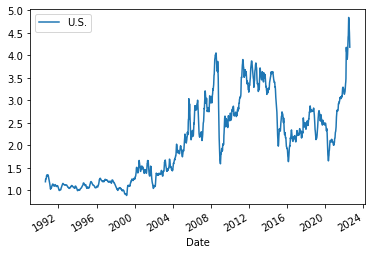

In [44]:
gas_all.plot();

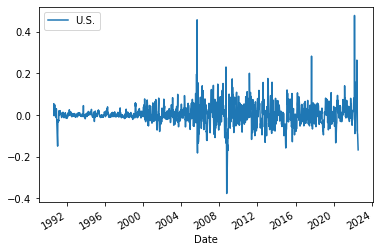

In [59]:
gas_all.diff().dropna().plot();

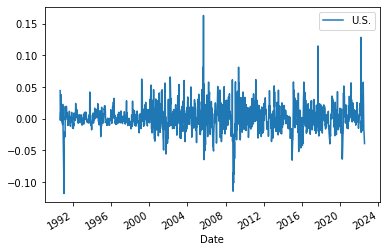

In [62]:
gas_log_all = np.log(gas_all)
gas_log_all.diff().dropna().plot();

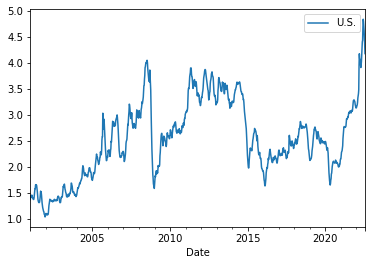

In [45]:
gas_2000_all.plot();

In [46]:
gas_adf = adfuller(gas_2000_all.diff().dropna())
print('ADF statistic ', gas_adf[0])
print('p-value ', gas_adf[1])

ADF statistic  -12.4777947692673
p-value  3.140018492464074e-23


<AxesSubplot:xlabel='Date'>

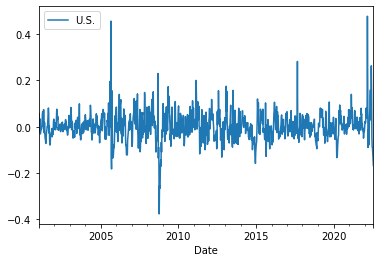

In [47]:
gas_2000_all.diff().dropna().plot()

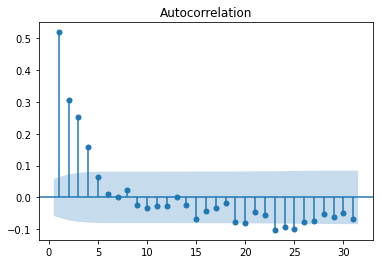

In [48]:
plot_acf(gas_2000_all.diff().dropna(), zero=False);

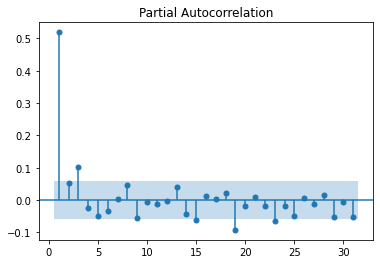

In [49]:
plot_pacf(gas_2000_all.diff().dropna(), zero=False);

<AxesSubplot:xlabel='Date'>

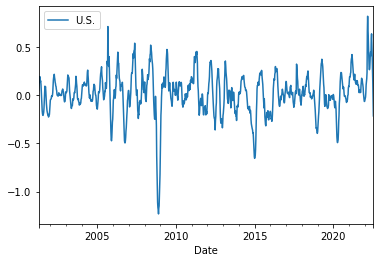

In [50]:
# plot ACF with no differencing to check for seasonality

gas_all_stationary = gas_2000_all - gas_2000_all.rolling(15).mean()
gas_all_stationary = gas_all_stationary.dropna()

gas_all_stationary.plot()

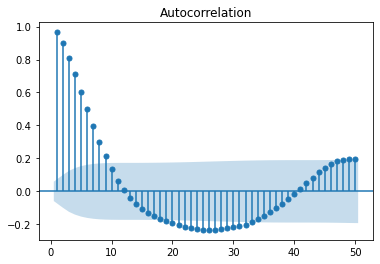

In [51]:
plot_acf(gas_all_stationary,lags = 50, zero=False);

In [52]:
gas_2000_train = gas_2000_all[gas_2000_all.index < '2019-01-01']
gas_2000_test = gas_2000_all[gas_2000_all.index >= '2019-01-01']

In [53]:
gas_model_best = pm.auto_arima(gas_2000_train,
                      seasonal=False,
                      d=1, 
                      start_p=1, start_q=1,
                      max_p=2, max_q=2,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True) 

# Print model summary
print(gas_model_best.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2936.808, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2652.464, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2929.904, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2864.929, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2654.277, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2936.487, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2937.950, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2895.904, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2937.788, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-2939.915, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-2897.818, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2938.768, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-2939.753, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2866.819, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0

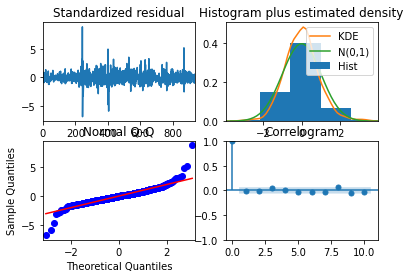

In [54]:
gas_model_best.plot_diagnostics();

In [55]:
gas_train_model = SARIMAX(gas_2000_train, order=(1,1,2))

gas_train_results = gas_train_model.fit()

gas_train_results.summary()

/Users/richardbradshaw/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/richardbradshaw/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   U.S.   No. Observations:                  940
Model:               SARIMAX(1, 1, 2)   Log Likelihood                1473.958
Date:                Mon, 01 Aug 2022   AIC                          -2939.915
Time:                        08:25:16   BIC                          -2920.536
Sample:                    01-01-2001   HQIC                         -2932.527
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7345      0.052     14.166      0.000       0.633       0.836
ma.L1         -0.2699      0.059     -4.599      0.000      -0.385      -0.155
ma.L2         -0.0789      0.034     -2.307      0.021      -0.146      -0.012
sigma2         0.0025   5.14e-05     49.315      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              4985.79
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                             0.51
Prob(H) (two-sided):                  0.01   Kurtosis:                        14.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

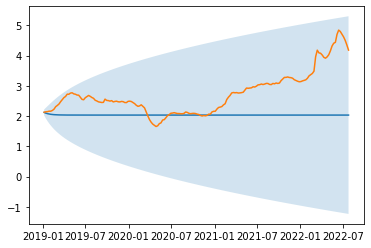

In [56]:
gas_train_forecast = gas_train_results.get_forecast(steps=len(gas_2000_test), dynamic=True)
gas_train_pred = gas_train_forecast.predicted_mean
gas_train_conf = gas_train_forecast.conf_int()

plt.plot(gas_2000_test.index, gas_train_pred)
plt.fill_between(gas_2000_test.index, gas_train_conf['lower U.S.'], gas_train_conf['upper U.S.'], alpha=0.2)
plt.plot(gas_2000_test)

### all gas forecast

In [57]:
gas_model = SARIMAX(gas_2000_all, order=(1,1,2))

gas_results = gas_model.fit()

/Users/richardbradshaw/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/richardbradshaw/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


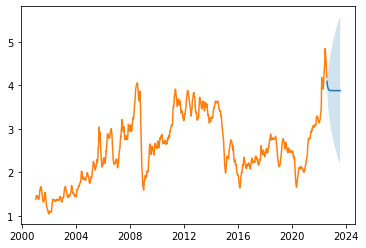

In [58]:
gas_forecast = gas_results.get_forecast(steps=52, dynamic=True)
gas_pred = gas_forecast.predicted_mean
gas_conf = gas_forecast.conf_int()

plt.plot(gas_pred)
plt.fill_between(gas_conf.index, gas_conf['lower U.S.'], gas_conf['upper U.S.'], alpha=0.2)
plt.plot(gas_2000_all);